# Hussaini lab data (Axona) conversion to NWB

Here, I am going to test code for doing said conversions.

### NWB

To convert to NWB we will need a separate Interface class (e.g. AxonaRecordingExtractorInterface) for each data type / extractor. Those are then combined with an NWBConverter class for the Lab (e.g. HussainiLabNWBConverter), which exports to NWB. 

Note that for Milestone2, we might not need any of this, since spikeextractors has its own NWBconverters for extractor and sorting classes!

Adapted from https://github.com/catalystneuro/movshon-lab-to-nwb/blob/main/tutorials/blackrock_nwb_conversion_detailed.ipynb

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import os

dir_name = r'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = 'axona_raw_5s'
filename = os.path.join(dir_name, base_filename)
set_file = filename + '.set'
print(filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/axona_raw_5s


In [3]:
!ls ../nwb-conversion-tools/nwb_conversion_tools -l

total 76
-rwxrwxrwx 1 sbuergers sbuergers    69 Apr  5 11:28 __init__.py
drwxrwxrwx 1 sbuergers sbuergers  4096 Apr 28 12:03 __pycache__
-rwxrwxrwx 1 sbuergers sbuergers  1404 Apr  5 11:28 auto_qc.py
-rwxrwxrwx 1 sbuergers sbuergers  1338 Apr  5 11:28 basedatainterface.py
-rwxrwxrwx 1 sbuergers sbuergers  2134 Apr  5 11:28 baseimagingextractorinterface.py
-rwxrwxrwx 1 sbuergers sbuergers  2775 May  3 13:30 baselfpextractorinterface.py
-rwxrwxrwx 1 sbuergers sbuergers  5052 May  3 13:30 baserecordingextractorinterface.py
-rwxrwxrwx 1 sbuergers sbuergers  2363 Apr  5 11:28 basesegmentationextractorinterface.py
-rwxrwxrwx 1 sbuergers sbuergers  3786 Apr 28 11:58 basesortingextractorinterface.py
-rwxrwxrwx 1 sbuergers sbuergers  5015 Apr 28 11:58 conversion_tools.py
drwxrwxrwx 1 sbuergers sbuergers  4096 May  3 13:30 datainterfaces
-rwxrwxrwx 1 sbuergers sbuergers  5100 Apr 28 11:58 json_schema_utils.py
-rwxrwxrwx 1 sbuergers sbuergers 10154 Apr  5 11:28 metafile.schema.json
-rwxrwxrwx 1 s

In [4]:
# Import modules

import random
import string
from typing import Union, Optional
from pathlib import Path
import spikeextractors as se
from pynwb import NWBFile
import numpy as np
import re
import datetime
import json
from jsonschema import validate, ValidationError

from nwb_conversion_tools.baserecordingextractorinterface import BaseRecordingExtractorInterface,  BaseDataInterface
from nwb_conversion_tools.basesortingextractorinterface import BaseSortingExtractorInterface
from nwb_conversion_tools.json_schema_utils import get_schema_from_method_signature, get_base_schema, fill_defaults
from nwb_conversion_tools.datainterfaces.interface_utils.brpylib import NsxFile
from nwb_conversion_tools import SpikeGLXRecordingInterface

In [5]:
# from basedatainterface.py
base_schema = get_base_schema(
    id_='metadata.schema.json',
    root=True,
    title='Metadata',
    description='Schema for the metadata',
    version="0.1.0",
)

In [6]:
base_schema

{'required': [],
 'properties': {},
 'type': 'object',
 'additionalProperties': False,
 '$schema': 'http://json-schema.org/draft-07/schema#',
 '$id': 'metadata.schema.json',
 'title': 'Metadata',
 'description': 'Schema for the metadata',
 'version': '0.1.0'}

In [7]:
glx = SpikeGLXRecordingInterface

In [8]:
glx.get_source_schema()

{'required': ['file_path'],
 'properties': {'file_path': {'type': 'string',
   'format': 'file',
   'description': 'Path to SpikeGLX file.'}},
 'type': 'object',
 'additionalProperties': True}

In [9]:
import inspect

inspect.signature(glx.__init__).parameters

mappingproxy({'self': <Parameter "self">,
              'file_path': <Parameter "file_path: Union[str, pathlib.Path, NoneType]">,
              'stub_test': <Parameter "stub_test: Union[bool, NoneType] = False">})

In [10]:
!ls ../spikeextractors/spikeextractors -l

total 224
-rwxrwxrwx 1 sbuergers sbuergers  1265 Mar 19 08:48 __init__.py
drwxrwxrwx 1 sbuergers sbuergers  4096 Apr 28 12:02 __pycache__
-rwxrwxrwx 1 sbuergers sbuergers 22834 Apr 27 20:11 baseextractor.py
-rwxrwxrwx 1 sbuergers sbuergers  9153 Apr 27 20:11 cacheextractors.py
drwxrwxrwx 1 sbuergers sbuergers  4096 Apr 20 21:40 example_datasets
-rwxrwxrwx 1 sbuergers sbuergers   105 Mar 19 08:48 exceptions.py
-rwxrwxrwx 1 sbuergers sbuergers 37347 Apr 27 20:11 extraction_tools.py
-rwxrwxrwx 1 sbuergers sbuergers  5952 Apr 28 11:50 extractorlist.py
drwxrwxrwx 1 sbuergers sbuergers  4096 Mar 22 09:47 extractors
-rwxrwxrwx 1 sbuergers sbuergers  6255 Apr 27 20:11 multirecordingchannelextractor.py
-rwxrwxrwx 1 sbuergers sbuergers  8547 Apr 27 20:11 multirecordingtimeextractor.py
-rwxrwxrwx 1 sbuergers sbuergers  5459 Apr 27 20:11 multisortingextractor.py
-rwxrwxrwx 1 sbuergers sbuergers 41337 Apr 27 20:11 recordingextractor.py
-rwxrwxrwx 1 sbuergers sbuergers 30652 Apr 27 20:11 sortingextr

In [11]:
from spikeextractors.extractors.neoextractors import AxonaRecordingExtractor

In [12]:
are = AxonaRecordingExtractor(filename=filename)
print('Number of channels:', are.get_num_channels())
print('Channel groups:', are.get_channel_groups())

Number of channels: 16
Channel groups: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


Parse .set file for metadata to include in metadata.

In [13]:
def parse_generic_header(filename, params):
    """
    Given a binary file with phrases and line breaks, enters the
    first word of a phrase as dictionary key and the following
    string (without linebreaks) as value. Returns the dictionary.
    
    INPUT
    filename (str): .set file path and name.
    params (list or set): parameter names to search for. 
    
    OUTPUT
    header (dict): dictionary with keys being the parameters that
                   were found & values being strings of the data.
                   
    EXAMPLE
    parse_generic_header('myset_file.set', ['experimenter', 'trial_time'])
    """
    header = {}
    params = set(params)
    with open(filename, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                break
            line = bin_line.decode('cp1252').replace('\r\n', '').replace('\r', '').strip()
            parts = line.split(' ')
            key = parts[0]
            if key in params:
                header[key] = ' '.join(parts[1:])
            
    return header

In [14]:
params_of_interest = [
    'experimenter', 
    'comments',
    'duration', 
    'sw_version',
    'tracker_version',
    'stim_version',
    'audio_version'
]

In [15]:
parse_generic_header(set_file, params_of_interest)

{'experimenter': 'Abid',
 'comments': '',
 'duration': '600.00625',
 'sw_version': '1.2.2.16',
 'tracker_version': '0',
 'stim_version': '1',
 'audio_version': '0'}

In [16]:
def read_iso_datetime(set_file):
    """ 
    Creates datetime object (y, m, d, h, m, s) from .set file header 
    """
    with open(set_file, 'r', encoding='cp1252') as f:
        for line in f:
            if line.startswith('trial_date'):
                date_string = re.findall(r'\d+\s\w+\s\d{4}$', line)[0]
            if line.startswith('trial_time'):
                time_string = line[len('trial_time')+1::].replace('\n', '')

    return datetime.datetime.strptime(date_string + ', ' + time_string, \
        "%d %b %Y, %H:%M:%S").isoformat()

In [17]:
class AxonaRecordingExtractorInterface(BaseRecordingExtractorInterface):
    """Primary data interface class for converting a AxonaRecordingExtractor."""

    RX = se.AxonaRecordingExtractor

    @classmethod
    def get_source_schema(cls):
        source_schema = {
            'required': ['filename'],
            'properties': {
                'filename': {
                    'type': 'string',
                    'format': 'file',
                    'description': 'Path to Axona files.'
                }
            },
            'type': 'object',
            'additionalProperties': True
        }
        return source_schema
        
    def get_metadata(self):
        """Auto-fill as much of the metadata as possible. Must comply with metadata schema."""        
                
        # Extract information for specific parameters from .set file
        params_of_interest = [
            'experimenter', 
            'comments',
            'duration', 
            'sw_version',
            'tracker_version',
            'stim_version',
            'audio_version'
        ]
        set_file = self.source_data['filename']+'.set'
        par = parse_generic_header(set_file, params_of_interest)
        
        # Extract information from AxonaRecordingExtractor
        elec_group_names = self.recording_extractor.get_channel_groups()
        unique_elec_group_names = set(elec_group_names)
        
        # Add available metadata
        metadata = super().get_metadata()
        metadata['NWBFile'] = dict(
            session_start_time=read_iso_datetime(set_file),
            session_description=par['comments'],
            session_duration=par['duration']+'s',
            experimenter=[par['experimenter']]
        )
        
        metadata['Ecephys'] = dict(
            Device=[
                dict(
                    name="Axona",
                    description="Axona DacqUSB, sw_version={}".format(par['sw_version']),
                    manufacturer="Axona"
                ),
            ],
            ElectrodeGroup=[
                dict(
                    name=f'Group{group_name}',
                    location='',
                    device='Axona',
                    description=f"Group {group_name} electrodes.",
                )
                for group_name in unique_elec_group_names
            ],
            Electrodes=[
                dict(
                    name='group_name',
                    description="The name of the ElectrodeGroup this electrode is a part of.",
                    data=[f"Group{x}" for x in elec_group_names]
                )
            ],
            ElectricalSeries=dict(
                name='ElectricalSeries',
                description="Raw acquisition traces."
            )
        )
  
        return metadata

In [18]:
"""Authors: Steffen Buergers (old)"""
import re
import datetime
import spikeextractors as se

from pynwb.ecephys import ElectricalSeries
from nwb_conversion_tools.utils import get_schema_from_hdmf_class
from nwb_conversion_tools.baserecordingextractorinterface import BaseRecordingExtractorInterface


def parse_generic_header(filename, params):
    """
    Given a binary file with phrases and line breaks, enters the
    first word of a phrase as dictionary key and the following
    string (without linebreaks) as value. Returns the dictionary.

    INPUT
    filename (str): .set file path and name.
    params (list or set): parameter names to search for.

    OUTPUT
    header (dict): dictionary with keys being the parameters that
                   were found & values being strings of the data.

    EXAMPLE
    parse_generic_header('myset_file.set', ['experimenter', 'trial_time'])
    """
    header = {}
    params = set(params)
    with open(filename, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                break
            line = bin_line.decode('cp1252').replace('\r\n', '').\
                replace('\r', '').strip()
            parts = line.split(' ')
            key = parts[0]
            if key in params:
                header[key] = ' '.join(parts[1:])

    return header


def read_iso_datetime(set_file):
    """
    Creates datetime object (y, m, d, h, m, s) from .set file header
    and converts it to ISO 8601 format
    """
    with open(set_file, 'r', encoding='cp1252') as f:
        for line in f:
            if line.startswith('trial_date'):
                date_string = re.findall(r'\d+\s\w+\s\d{4}$', line)[0]
            if line.startswith('trial_time'):
                time_string = line[len('trial_time')+1::].replace('\n', '')

    return datetime.datetime.strptime(date_string + ', ' + time_string,
                                      "%d %b %Y, %H:%M:%S").isoformat()


class AxonaRecordingExtractorInterface(BaseRecordingExtractorInterface):
    """Primary data interface class for converting a AxonaRecordingExtractor"""

    RX = se.AxonaRecordingExtractor

    @classmethod
    def get_source_schema(cls):
        source_schema = {
            'required': ['filename'],
            'properties': {
                'filename': {
                    'type': 'string',
                    'format': 'file',
                    'description': 'Path to Axona files.'
                }
            },
            'type': 'object',
            'additionalProperties': True
        }
        return source_schema
    
    def get_metadata_schema(self):
        metadata_schema = super().get_metadata_schema()
        
        # Update Ecephys metadata
        Electrodes = {
            "required": [
                "name",
                "description",
                "data"
            ],
            "properties": {
                "name": {
                    "description": "Electrode group name this electrode is a part of.",
                    "type": "string"
                },
                "description": {
                    "description": "Description of this electrode group",
                    "type": "string"
                },
                "data": {
                    "description": "Electrode group name for each electrode.",
                    "type": "array",
                }
            },
            "type": "array",
            "additionalProperties": False,
            "tag": "Electrodes"
        }
        
        metadata_schema['properties']['Ecephys']['properties'].update(
            Electrodes=Electrodes,
            ElectricalSeries=get_schema_from_hdmf_class(ElectricalSeries),
        )

        return metadata_schema

    def get_metadata(self):

        # Extract information for specific parameters from .set file
        params_of_interest = [
            'experimenter',
            'comments',
            'duration',
            'sw_version'
        ]
        set_file = self.source_data['filename'].split('.')[0]+'.set'
        par = parse_generic_header(set_file, params_of_interest)

        # Extract information from AxonaRecordingExtractor
        elec_group_names = self.recording_extractor.get_channel_groups()
        unique_elec_group_names = set(elec_group_names)

        # Add available metadata
        metadata = super().get_metadata()
        metadata['NWBFile'] = dict(
            session_start_time=read_iso_datetime(set_file),
            session_description=par['comments'],
            #session_duration=par['duration']+'s',
            experimenter=[par['experimenter']]
        )

        metadata['Ecephys'] = dict(
            Device=[
                dict(
                    name="Axona",
                    description="Axona DacqUSB, sw_version={}"
                                .format(par['sw_version']),
                    manufacturer="Axona"
                ),
            ],
            ElectrodeGroup=[
                dict(
                    name=f'Group{group_name}',
                    location='',
                    device='Axona',
                    description=f"Group {group_name} electrodes.",
                )
                for group_name in unique_elec_group_names
            ],
            Electrodes=[
                dict(
                    name='group_name',
                    description="The name of the ElectrodeGroup this electrode is a part of.",
                    data=[f"Group{x}" for x in elec_group_names]
                )
            ],
            ElectricalSeries=dict(
                name='ElectricalSeries',
                description="Raw acquisition traces."
            )
        )

        return metadata

In [19]:
"""Authors: Steffen Buergers"""
import re
import datetime
import spikeextractors as se

from pynwb.ecephys import ElectricalSeries
from nwb_conversion_tools.utils import get_schema_from_hdmf_class
from nwb_conversion_tools.basedatainterface import BaseDataInterface
from nwb_conversion_tools.baserecordingextractorinterface import (
    BaseRecordingExtractorInterface
)


def parse_generic_header(filename, params):
    """
    Given a binary file with phrases and line breaks, enters the
    first word of a phrase as dictionary key and the following
    string (without linebreaks) as value. Returns the dictionary.

    INPUT
    filename (str): .set file path and name.
    params (list or set): parameter names to search for.

    OUTPUT
    header (dict): dictionary with keys being the parameters that
                   were found & values being strings of the data.

    EXAMPLE
    parse_generic_header('myset_file.set', ['experimenter', 'trial_time'])
    """
    header = {}
    params = set(params)
    with open(filename, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                break
            line = bin_line.decode('cp1252').replace('\r\n', '').\
                replace('\r', '').strip()
            parts = line.split(' ')
            key = parts[0]
            if key in params:
                header[key] = ' '.join(parts[1:])

    return header


def read_iso_datetime(set_file):
    """
    Creates datetime object (y, m, d, h, m, s) from .set file header
    and converts it to ISO 8601 format
    """
    with open(set_file, 'r', encoding='cp1252') as f:
        for line in f:
            if line.startswith('trial_date'):
                date_string = re.findall(r'\d+\s\w+\s\d{4}$', line)[0]
            if line.startswith('trial_time'):
                time_string = line[len('trial_time')+1::].replace('\n', '')

    return datetime.datetime.strptime(date_string + ', ' + time_string,
                                      "%d %b %Y, %H:%M:%S").isoformat()


class AxonaRecordingExtractorInterface(BaseRecordingExtractorInterface):
    """Primary data interface class for converting a AxonaRecordingExtractor"""

    RX = se.AxonaRecordingExtractor

    @classmethod
    def get_source_schema(cls):
        source_schema = {
            'required': ['filename'],
            'properties': {
                'filename': {
                    'type': 'string',
                    'format': 'file',
                    'description': 'Path to Axona files.'
                }
            },
            'type': 'object',
            'additionalProperties': True
        }
        return source_schema

    def get_metadata_schema(self):
        metadata_schema = super().get_metadata_schema()

        # Update Ecephys metadata
        Electrodes = {
            "required": [
                "name",
                "description",
                "data"
            ],
            "properties": {
                "name": {
                    "description": "Electrode group name this electrode is a part of.",
                    "type": "string"
                },
                "description": {
                    "description": "Description of this electrode group",
                    "type": "string"
                },
                "data": {
                    "description": "Electrode group name for each electrode.",
                    "type": "array",
                }
            },
            "type": "array",
            "additionalProperties": False,
            "tag": "Electrodes"
        }

        metadata_schema['properties']['Ecephys']['properties'].update(
            Electrodes=Electrodes,
            ElectricalSeries=get_schema_from_hdmf_class(ElectricalSeries),
        )

        return metadata_schema

    def get_metadata(self):

        # Extract information for specific parameters from .set file
        params_of_interest = [
            'experimenter',
            'comments',
            'duration',
            'sw_version'
        ]
        set_file = self.source_data['filename'].split('.')[0]+'.set'
        par = parse_generic_header(set_file, params_of_interest)

        # Extract information from AxonaRecordingExtractor
        elec_group_names = self.recording_extractor.get_channel_groups()
        unique_elec_group_names = set(elec_group_names)

        # Add available metadata
        metadata = super().get_metadata()
        metadata['NWBFile'] = dict(
            session_start_time=read_iso_datetime(set_file),
            session_description=par['comments'],
            experimenter=[par['experimenter']]
        )

        metadata['Ecephys'] = dict(
            Device=[
                dict(
                    name="Axona",
                    description="Axona DacqUSB, sw_version={}"
                                .format(par['sw_version']),
                    manufacturer="Axona"
                ),
            ],
            ElectrodeGroup=[
                dict(
                    name=f'Group{group_name}',
                    location='',
                    device='Axona',
                    description=f"Group {group_name} electrodes.",
                )
                for group_name in unique_elec_group_names
            ],
            Electrodes=[
                dict(
                    name='group_name',
                    description="The name of the ElectrodeGroup this electrode is a part of.",
                    data=[f"Group{x}" for x in elec_group_names]
                )
            ],
            ElectricalSeries=dict(
                name='ElectricalSeries',
                description="Raw acquisition traces."
            )
        )

        return metadata


class AxonaPositionDataInterface(BaseDataInterface):
    """Primary data interface class for converting a AxonaRecordingExtractor"""
    pass

In [20]:
RXI = AxonaRecordingExtractorInterface(filename=filename)

In [21]:
RXI.get_metadata()

{'NWBFile': {'session_start_time': '2020-10-04T11:07:07',
  'session_description': '',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.',
    'data': ['Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group1',
     'Group1',
     'Group1',
     'Group1',
     'Group2',
     'Group2',
     'Group2',
     'Gr

In [22]:
base_metadata_schema = RXI.get_metadata_schema()

In [23]:
print(json.dumps(base_metadata_schema, indent=2))

{
  "required": [],
  "properties": {
    "Ecephys": {
      "required": [
        "Device",
        "ElectrodeGroup"
      ],
      "properties": {
        "Device": {
          "type": "array",
          "minItems": 1,
          "items": {
            "$ref": "#/properties/Ecephys/properties/definitions/Device"
          }
        },
        "ElectrodeGroup": {
          "type": "array",
          "minItems": 1,
          "items": {
            "$ref": "#/properties/Ecephys/properties/definitions/ElectrodeGroup"
          }
        },
        "definitions": {
          "Device": {
            "required": [
              "name"
            ],
            "properties": {
              "name": {
                "description": "the name of this device",
                "type": "string"
              },
              "description": {
                "description": "Description of the device (e.g., model, firmware version, processing software version, etc.)",
                "type": "strin

In [25]:
# The metadata_schema does not validate with the metadata, bc
# the full metadata_schema is only inherited when defining the
# nwbconverter (see below).

try:
    validate(
        instance=RXI.get_metadata(),
        schema=RXI.get_metadata_schema()
    )
    print('validation SUCCESS')
except ValidationError:
    print('validation FAILED')

validation FAILED


In [26]:
from nwb_conversion_tools import (
    NWBConverter
)


class HussainiNWBConverter(NWBConverter):
    
    #@classmethod
    #def validate_source(cls, source_data):
    #    """Validate source_data against Converter source_schema."""
    #    validate(instance=source_data, schema=cls.get_source_schema())
    #    print('Source data is valid!')
    # 
    data_interface_classes = dict(
        AxonaRecordingExtractorInterface=AxonaRecordingExtractorInterface
    )

In [29]:
# Get source_schema from converter

source_schema = HussainiNWBConverter.get_source_schema()
print(json.dumps(source_schema['properties'], indent=2))

{
  "AxonaRecordingExtractorInterface": {
    "required": [
      "filename"
    ],
    "properties": {
      "filename": {
        "type": "string",
        "format": "file",
        "description": "Path to Axona files."
      }
    },
    "type": "object",
    "additionalProperties": true
  }
}


In [28]:
# Define source data (required for instantiating converter)

source_data = dict(
    AxonaRecordingExtractorInterface=dict(
        filename=filename
    )
)

print(json.dumps(source_data, indent=2))

{
  "AxonaRecordingExtractorInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/axona_raw_5s"
  }
}


In [30]:
HussainiNWBConverter.data_interface_classes

{'AxonaRecordingExtractorInterface': __main__.AxonaRecordingExtractorInterface}

In [31]:
HussainiNWBConverter.data_interface_classes.items()

dict_items([('AxonaRecordingExtractorInterface', <class '__main__.AxonaRecordingExtractorInterface'>)])

In [32]:
validate(instance=source_data, schema=HussainiNWBConverter.get_source_schema())

In [33]:
HussainiNWBConverter.get_source_schema()

{'required': [],
 'properties': {'AxonaRecordingExtractorInterface': {'required': ['filename'],
   'properties': {'filename': {'type': 'string',
     'format': 'file',
     'description': 'Path to Axona files.'}},
   'type': 'object',
   'additionalProperties': True}},
 'type': 'object',
 'additionalProperties': False,
 '$schema': 'http://json-schema.org/draft-07/schema#',
 '$id': 'source.schema.json',
 'title': 'Source data schema',
 'description': 'Schema for the source data, files and directories',
 'version': '0.1.0'}

In [34]:
# Instantiate Hussaini-lab converter

HussainiNWBConverter.validate_source(source_data=source_data)

Source data is valid!


In [35]:
# Get metadata_schema from converter

converter = HussainiNWBConverter(source_data=source_data)
metadata_schema = converter.get_metadata_schema()
print(json.dumps(metadata_schema['properties'], indent=2))

Source data is valid!
{
  "NWBFile": {
    "required": [
      "session_description",
      "identifier",
      "session_start_time"
    ],
    "properties": {
      "session_description": {
        "type": "string",
        "format": "long",
        "description": "a description of the session where this data was generated",
        "default": ""
      },
      "identifier": {
        "type": "string",
        "description": "a unique text identifier for the file",
        "default": "26118e57-7a2a-42d2-8903-4fdad04c16f6"
      },
      "session_start_time": {
        "type": "string",
        "description": "the start date and time of the recording session",
        "format": "date-time",
        "default": "2020-10-04T11:07:07"
      },
      "experimenter": {
        "type": "array",
        "items": {
          "type": "string",
          "title": "experimenter"
        },
        "description": "name of person who performed experiment",
        "default": [
          "Abid"
     

In [36]:
metadata = converter.get_metadata()
metadata

{'NWBFile': {'session_description': '',
  'session_start_time': '2020-10-04T11:07:07',
  'identifier': '3588465a-da31-4c13-9934-4778f62b3679',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.',
    'data': ['Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group1',
     'Group1',
     'Group1',
     'Group1

In [37]:
metadata['Ecephys']

{'Device': [{'name': 'Axona',
   'description': 'Axona DacqUSB, sw_version=1.2.2.16',
   'manufacturer': 'Axona'}],
 'ElectrodeGroup': [{'name': 'Group0',
   'location': '',
   'device': 'Axona',
   'description': 'Group 0 electrodes.'},
  {'name': 'Group1',
   'location': '',
   'device': 'Axona',
   'description': 'Group 1 electrodes.'},
  {'name': 'Group2',
   'location': '',
   'device': 'Axona',
   'description': 'Group 2 electrodes.'},
  {'name': 'Group3',
   'location': '',
   'device': 'Axona',
   'description': 'Group 3 electrodes.'}],
 'Electrodes': [{'name': 'group_name',
   'description': 'The name of the ElectrodeGroup this electrode is a part of.',
   'data': ['Group0',
    'Group0',
    'Group0',
    'Group0',
    'Group1',
    'Group1',
    'Group1',
    'Group1',
    'Group2',
    'Group2',
    'Group2',
    'Group2',
    'Group3',
    'Group3',
    'Group3',
    'Group3']}],
 'ElectricalSeries': {'name': 'ElectricalSeries',
  'description': 'Raw acquisition traces.'}}

In [38]:
# Validate metadata with metadata_schema from nwbconverter

validate(
    instance=converter.get_metadata(),
    schema=converter.get_metadata_schema()
)

## Implement AxonaPositionDataInterface

In [43]:
"""Authors: Steffen Buergers"""
import re
import datetime

import spikeextractors as se

from pynwb.ecephys import ElectricalSeries
from pynwb.behavior import SpatialSeries

from nwb_conversion_tools.utils import get_schema_from_hdmf_class
from nwb_conversion_tools.basedatainterface import BaseDataInterface
from nwb_conversion_tools.baserecordingextractorinterface import (
    BaseRecordingExtractorInterface
)


def parse_generic_header(filename, params):
    """
    Given a binary file with phrases and line breaks, enters the
    first word of a phrase as dictionary key and the following
    string (without linebreaks) as value. Returns the dictionary.

    INPUT
    filename (str): .set file path and name.
    params (list or set): parameter names to search for.

    OUTPUT
    header (dict): dictionary with keys being the parameters that
                   were found & values being strings of the data.

    EXAMPLE
    parse_generic_header('myset_file.set', ['experimenter', 'trial_time'])
    """
    header = {}
    params = set(params)
    with open(filename, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                break
            line = bin_line.decode('cp1252').replace('\r\n', '').\
                replace('\r', '').strip()
            parts = line.split(' ')
            key = parts[0]
            if key in params:
                header[key] = ' '.join(parts[1:])

    return header


def read_iso_datetime(set_file):
    """
    Creates datetime object (y, m, d, h, m, s) from .set file header
    and converts it to ISO 8601 format
    """
    with open(set_file, 'r', encoding='cp1252') as f:
        for line in f:
            if line.startswith('trial_date'):
                date_string = re.findall(r'\d+\s\w+\s\d{4}$', line)[0]
            if line.startswith('trial_time'):
                time_string = line[len('trial_time')+1::].replace('\n', '')

    return datetime.datetime.strptime(date_string + ', ' + time_string,
                                      "%d %b %Y, %H:%M:%S").isoformat()


class AxonaRecordingExtractorInterface(BaseRecordingExtractorInterface):
    """Primary data interface class for converting a AxonaRecordingExtractor"""

    RX = se.AxonaRecordingExtractor

    @classmethod
    def get_source_schema(cls):
        source_schema = {
            'required': ['filename'],
            'properties': {
                'filename': {
                    'type': 'string',
                    'format': 'file',
                    'description': 'Full filename of Axona .set file (or other)'
                }
            },
            'type': 'object',
            'additionalProperties': True
        }
        return source_schema

    def get_metadata_schema(self):
        metadata_schema = super().get_metadata_schema()

        # Update Ecephys metadata
        Electrodes = {
            "required": [
                "name",
                "description",
                "data"
            ],
            "properties": {
                "name": {
                    "description": "Electrode group name this electrode is a part of.",
                    "type": "string"
                },
                "description": {
                    "description": "Description of this electrode group",
                    "type": "string"
                },
                "data": {
                    "description": "Electrode group name for each electrode.",
                    "type": "array",
                }
            },
            "type": "array",
            "additionalProperties": False,
            "tag": "Electrodes"
        }

        metadata_schema['properties']['Ecephys']['properties'].update(
            Electrodes=Electrodes,
            ElectricalSeries=get_schema_from_hdmf_class(ElectricalSeries),
        )

        return metadata_schema

    def get_metadata(self):

        # Extract information for specific parameters from .set file
        params_of_interest = [
            'experimenter',
            'comments',
            'duration',
            'sw_version'
        ]
        set_file = self.source_data['filename'].split('.')[0]+'.set'
        par = parse_generic_header(set_file, params_of_interest)

        # Extract information from AxonaRecordingExtractor
        elec_group_names = self.recording_extractor.get_channel_groups()
        unique_elec_group_names = set(elec_group_names)

        # Add available metadata
        metadata = super().get_metadata()
        metadata['NWBFile'] = dict(
            session_start_time=read_iso_datetime(set_file),
            session_description=par['comments'],
            experimenter=[par['experimenter']]
        )

        metadata['Ecephys'] = dict(
            Device=[
                dict(
                    name="Axona",
                    description="Axona DacqUSB, sw_version={}"
                                .format(par['sw_version']),
                    manufacturer="Axona"
                ),
            ],
            ElectrodeGroup=[
                dict(
                    name=f'Group{group_name}',
                    location='',
                    device='Axona',
                    description=f"Group {group_name} electrodes.",
                )
                for group_name in unique_elec_group_names
            ],
            Electrodes=[
                dict(
                    name='group_name',
                    description="The name of the ElectrodeGroup this electrode is a part of.",
                    data=[f"Group{x}" for x in elec_group_names]
                )
            ],
            ElectricalSeries=dict(
                name='ElectricalSeries',
                description="Raw acquisition traces."
            )
        )

        return metadata


class AxonaPositionDataInterface(BaseDataInterface):
    """Primary data interface class for converting a AxonaRecordingExtractor"""

    @classmethod
    def get_source_schema(cls): 
        
        source_schema = {
            'required': ['filename'],
            'properties': {
                'filename': {
                    'type': 'string',
                    'format': 'file',
                    'description': 'Full filename of Axona .bin or .pos file'
                }
            },
            'type': 'object',
            'additionalProperties': True
        }

        return source_schema

    def run_conversion(self, nwbfile: NWBFile, metadata: dict):
        """
        Run conversion for this data interface.
        
        Parameters
        ----------
        nwbfile : NWBFile
        metadata : dict
        """
        
        # TODO: Do I need to create the NWBFile from metadata if 
        # it does not exist yet?
        
        # Get sync offset time to add to Expo trials timestamps
        ttl_file = self.source_data['ttl_file']
        t_offset = 0
        if Path(ttl_file).is_file():
            if ttl_file.endswith('.continuous'):  # OpenEphys
                t_offset = get_first_sync_time_openephys(filepath=ttl_file)
            elif '.imec.' in ttl_file:  # SpikeGLX
                t_offset = get_first_sync_time_spikeglx(filepath=ttl_file)
        print(f'Trials sync offset: {t_offset}')

        expo_file = self.source_data['expo_file']
        if expo_file.endswith('.xml'):
            trials = process_passesV2(expo_file)
            blocks = process_blocksV2(expo_file)
        else:
            raise OSError(f"Expo file should be of xml type. File used: {expo_file}")

        # Add trials intervals values only if no trials data exists in nwbfile
        if nwbfile.trials is not None:
            print('Trials already exist in current nwb file. Expo trials intervals not added.')
        else:
            # Get parameters names to form trials columns
            col_names = list()
            for params in blocks.values():
                for p in params.keys():
                    if p not in col_names:
                        col_names.append(p)

            # Add trials columns
            for c in col_names:
                nwbfile.add_trial_column(
                    name=c,
                    description='no description'
                )
                
            # Add trials rows
            for tr in trials.values():
                trial_dict = dict(
                    start_time=tr['StartTime'] + t_offset, 
                    stop_time=tr['EndTime'] + t_offset
                )
                for c in col_names:
                    trial_dict[c] = blocks[str(tr['BlockID'])].get(c, '')
                    
                nwbfile.add_trial(**trial_dict)

In [ ]:
# TODO: See if I can also read .pos data, not just .bin!

In [119]:
bin_file = filename + '.bin'
bin_file

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.bin.bin'

In [120]:
set_file = filename.split('.')[0]+'.set'
par = parse_generic_header(set_file, ['rawRate'])
int(par['rawRate'])

48000

In [121]:
filename = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.bin'

In [122]:
def establish_mmap_to_position_data(filename):
    '''
    Generates a memory map (mmap) object connected to an Axona .bin
    file, referencing only the animal position data (if present).
    
    When no .bin file is available or no position data is included,
    returns None.
    
    TODO: Also allow using .pos file (currently only support .bin)
    
    Parameters:
    -------
    filename (Path or Str): Full filename of Axona file with any 
        extension.
        
    Returns:
    -------
    mm (mmap or None): Memory map to .bin file position data
    '''
    import contextlib
    import mmap
    
    mmpos = None

    bin_file = filename.split('.')[0]+'.bin'
    set_file = filename.split('.')[0]+'.set'
    par = parse_generic_header(set_file, ['rawRate', 'duration'])
    sr_ecephys = int(par['rawRate'])
    sr_pos = 100
    bytes_packet = 432

    num_packets = int(os.path.getsize(bin_file) / bytes_packet)
    num_ecephys_samples = num_packets * 3
    dur_ecephys = num_ecephys_samples / sr_ecephys
    assert dur_ecephys == float(par['duration'])

    # Check if position data exists in .bin file
    with open(bin_file, 'rb') as f:
        with contextlib.closing(
            mmap.mmap(f.fileno(), sr_ecephys // 3 // sr_pos
                      * bytes_packet, access=mmap.ACCESS_READ)
        ) as mmap_obj:
            contains_pos_tracking = mmap_obj.find(b'ADU2') > -1

    # Establish memory map to .bin file, considering only position data
    if contains_pos_tracking:
        num_channels_pos = 8
        dur_pos = dur_ecephys
        num_pos_samples = int(dur_pos * sr_pos)

        fbin = open(bin_file, 'rb')
        mmpos = mmap.mmap(fbin.fileno(), 0, access=mmap.ACCESS_READ)
    
    return mmpos

In [125]:
def read_bin_file_position_data(filename):
    '''
    Reads position data from Axona .bin file (if present in 
    recording) and returns it as a numpy.array.
    
    Parameters:
    -------
    filename (Path or Str): Full filename of Axona file with any 
        extension.
    
    Returns:
    -------
    pos (np.array)
    '''
    bin_file = filename.split('.')[0]+'.bin'
    mm = establish_mmap_to_position_data(bin_file)
    
    bytes_packet = 432
    num_packets = int(os.path.getsize(bin_file) / bytes_packet)
    
    set_file = filename.split('.')[0]+'.set'
    par = parse_generic_header(set_file, ['rawRate', 'duration'])
    sr_ecephys = int(par['rawRate'])
    
    pos = np.array([]).astype(float)

    flags = np.ndarray((num_packets,), 'S4', mm, 0, bytes_packet)
    ADU2_idx = np.where(flags == b'ADU2')

    pos = np.ndarray(
        (num_packets,), (np.int16, (1, 8)), mm, 16, (bytes_packet,)
    ).reshape((-1, 8))[ADU2_idx][:]

    pos = np.hstack((ADU2_idx[0].reshape((-1, 1)), pos)).astype(float)

    # The timestamp from the recording is dubious, create our own
    packets_per_ms = sr_ecephys / 3000
    pos[:, 0] = pos[:, 0] / packets_per_ms
    pos = np.delete(pos, 1, 1)
    
    return pos

posidtion_data dimensions: (59965, 8)
Timestamps: [6.25000e-02 8.75000e-01 6.37500e+00 1.63750e+01 2.63750e+01 3.63750e+01
 4.63750e+01 5.63750e+01 6.63750e+01 7.63750e+01 8.63750e+01 9.63750e+01
 1.06375e+02 1.16375e+02 1.26375e+02 1.36375e+02 1.46375e+02 1.56375e+02
 1.66375e+02 1.76375e+02]
Difference between timestamps: [ 0.8125  5.5    10.     10.     10.     10.     10.     10.     10.
 10.     10.     10.     10.     10.     10.     10.     10.     10.
 10.     10.    ]


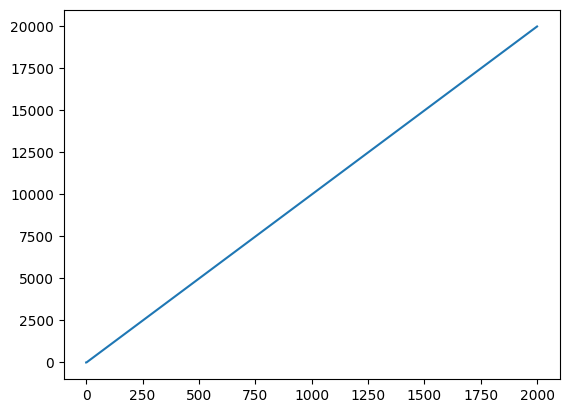

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt

position_data = read_bin_file_position_data(filename)
print('posidtion_data dimensions:', position_data.shape)

position_timestamps = position_data[:, 0]
print('Timestamps:', position_timestamps[0:20])

ts_diff = position_timestamps[1:] - position_timestamps[:-1]
print('Difference between timestamps:', ts_diff[0:20])

plt.plot(position_timestamps[0:2000])

In [128]:
position_data.shape

(59965, 8)

In [130]:
# Run conversion of position data to NWB format
# channel by channel

from pynwb.behavior import Position

position = Position()

position_channel_names = 't,x1,y1,x2,y2,numpix1,numpix2,unused'.split(',')
position_data = read_bin_file_position_data(filename)
position_timestamps = position_data[:, 0]

for ichan in range(0, position_data.shape[1]):
    
    spatial_series = SpatialSeries(
        name=position_channel_names[ichan],
        timestamps=position_timestamps,
        data=position_data[:, ichan],
        reference_frame='start of raw aquisition (.bin file)'
    )

    position.add_spatial_series(spatial_series)
    
position

Position pynwb.behavior.Position at 0x139664969841296
Fields:
  spatial_series: {
    numpix1 <class 'pynwb.behavior.SpatialSeries'>,
    numpix2 <class 'pynwb.behavior.SpatialSeries'>,
    t <class 'pynwb.behavior.SpatialSeries'>,
    unused <class 'pynwb.behavior.SpatialSeries'>,
    x1 <class 'pynwb.behavior.SpatialSeries'>,
    x2 <class 'pynwb.behavior.SpatialSeries'>,
    y1 <class 'pynwb.behavior.SpatialSeries'>,
    y2 <class 'pynwb.behavior.SpatialSeries'>
  }

#### Familiarize a bit with handling nwbfile objects

In [51]:
from nwb_conversion_tools.conversion_tools import (
    get_default_nwbfile_metadata, make_nwbfile_from_metadata
)

nwbfile = make_nwbfile_from_metadata(metadata=metadata)

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")


Follow tutorial guidelines for creating Position data in pynwb!

See this tutorial on DataInterfaces in NWB: https://pynwb.readthedocs.io/en/stable/tutorials/general/file.html

NWB provides the concept of a data interface–an object for a standard storage location of specific types of data–through the NWBDataInterface class. For example, Position provides a container that holds one or more SpatialSeries objects. SpatialSeries is a subtype of TimeSeries that represents the spatial position of an animal over time. By putting your position data into a Position container, downstream users and tools know where to look to retrieve position data. For a comprehensive list of available data interfaces, see the overview page. Here is how to create a Position object named ‘Position’ [3].

In [56]:
from pynwb.behavior import Position

position = Position()

You can add objects to a data interface as a method of the data interface:

In [58]:
position.create_spatial_series(name='position1',
                               data=np.linspace(0, 1, 20),
                               rate=50.,
                               reference_frame='starting gate')

position1 pynwb.behavior.SpatialSeries at 0x139665061120656
Fields:
  comments: no comments
  conversion: 1.0
  data: [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
  description: no description
  rate: 50.0
  reference_frame: starting gate
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: meters

or you can add pre-existing objects:



In [59]:
from pynwb.behavior import SpatialSeries

spatial_series = SpatialSeries(name='position',
                               data=position_data,
                               reference_frame='start of raw aquisition (.bin file)')

position.add_spatial_series(spatial_series)

position2 pynwb.behavior.SpatialSeries at 0x139665061710864
Fields:
  comments: no comments
  conversion: 1.0
  data: [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
  description: no description
  rate: 50.0
  reference_frame: starting gate
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: meters

or include the object during construction:

In [60]:
spatial_series = SpatialSeries(name='position2',
                               data=np.linspace(0, 1, 20),
                               rate=50.,
                               reference_frame='starting gate')

position = Position(spatial_series=spatial_series)

In [61]:
position

Position pynwb.behavior.Position at 0x139665061118256
Fields:
  spatial_series: {
    position2 <class 'pynwb.behavior.SpatialSeries'>
  }

In [46]:
bi = BaseDataInterface(source_data=filename)
bi.get_conversion_options_schema()

TypeError: Can't instantiate abstract class BaseDataInterface with abstract methods run_conversion

In [48]:
from nwb_conversion_tools.json_schema_utils import (
    get_base_schema, get_schema_from_method_signature, fill_defaults)

In [49]:
get_schema_from_method_signature(BaseDataInterface.run_conversion, exclude=['nwbfile', 'metadata'])

ValueError: No valid arguments were found in the json type mapping!

## Test axonadatainterface from nwb_conversion_tools

In [ ]:
import json
from jsonschema import validate

In [ ]:
import os

dir_name = r'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = 'axona_raw_5s'
filename = os.path.join(dir_name, base_filename)
print(filename)

In [25]:
from nwb_conversion_tools import axonadatainterface

In [26]:
from nwb_conversion_tools import (
    NWBConverter, AxonaRecordingExtractorInterface
)

In [27]:
import sys
sys.path.append('/mnt/d/spikeinterface/hussaini-lab-to-nwb/hussaini_lab_to_nwb')

In [28]:
from hussaininwbconverter import HussainiNWBConverter

In [29]:
# Get source_schema from converter

source_schema = HussainiNWBConverter.get_source_schema()
print(json.dumps(source_schema['properties'], indent=2))

{
  "AxonaRecordingExtractorInterface": {
    "required": [
      "filename"
    ],
    "properties": {
      "filename": {
        "type": "string",
        "format": "file",
        "description": "Path to Axona files."
      }
    },
    "type": "object",
    "additionalProperties": true
  }
}


In [30]:
source_data = dict(
    AxonaRecordingExtractorInterface=dict(
        filename=filename
    )
)
print(json.dumps(source_data, indent=2))

{
  "AxonaRecordingExtractorInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/axona_raw_5s"
  }
}


In [31]:
# Validate source_data with source_schema

validate(
    instance=source_data,
    schema=source_schema
)

In [32]:
# Instantiate Hussaini-lab converter

converter = HussainiNWBConverter(source_data=source_data)

Source data is valid!


In [33]:
import datetime

In [34]:
# Get metadata_schema from converter
metadata = converter.get_metadata()
metadata

{'NWBFile': {'session_description': '',
  'session_start_time': '2020-10-04T11:07:07',
  'identifier': 'e5db422b-34e6-438b-bba7-7310cb409366',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.',
    'data': ['Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group1',
     'Group1',
     'Group1',
     'Group1

In [35]:
get_schema_from_hdmf_class(ElectricalSeries)

{'required': ['name'],
 'properties': {'name': {'description': 'The name of this TimeSeries dataset',
   'type': 'string'},
  'resolution': {'description': 'The smallest meaningful difference (in specified unit) between values in data',
   'type': 'number',
   'default': -1.0},
  'conversion': {'description': 'Scalar to multiply each element in data to convert it to the specified unit',
   'type': 'number',
   'default': 1.0},
  'starting_time': {'description': 'The timestamp of the first sample',
   'type': 'number'},
  'rate': {'description': 'Sampling rate in Hz', 'type': 'number'},
  'comments': {'description': 'Human-readable comments about this TimeSeries dataset',
   'type': 'string',
   'default': 'no comments'},
  'description': {'description': 'Description of this TimeSeries dataset',
   'type': 'string',
   'default': 'no description'}},
 'type': 'object',
 'additionalProperties': False,
 'tag': 'pynwb.ecephys.ElectricalSeries'}

In [36]:
converter.get_metadata_schema()

{'required': ['NWBFile'],
 'properties': {'NWBFile': {'required': ['session_description',
    'identifier',
    'session_start_time'],
   'properties': {'session_description': {'type': 'string',
     'format': 'long',
     'description': 'a description of the session where this data was generated',
     'default': ''},
    'identifier': {'type': 'string',
     'description': 'a unique text identifier for the file',
     'default': 'dbf47d28-0940-43e2-b922-73e270c18653'},
    'session_start_time': {'type': 'string',
     'description': 'the start date and time of the recording session',
     'format': 'date-time',
     'default': '2020-10-04T11:07:07'},
    'experimenter': {'type': 'array',
     'items': {'type': 'string', 'title': 'experimenter'},
     'description': 'name of person who performed experiment',
     'default': ['Abid']},
    'experiment_description': {'type': 'string',
     'description': 'general description of the experiment'},
    'session_id': {'type': 'string',
    

In [37]:
# Validate metadata with metadata_schema from nwbconverter

validate(
    instance=converter.get_metadata(),
    schema=converter.get_metadata_schema()
)

In [38]:
print(json.dumps(converter.get_metadata_schema(), indent=2))

{
  "required": [
    "NWBFile"
  ],
  "properties": {
    "NWBFile": {
      "required": [
        "session_description",
        "identifier",
        "session_start_time"
      ],
      "properties": {
        "session_description": {
          "type": "string",
          "format": "long",
          "description": "a description of the session where this data was generated",
          "default": ""
        },
        "identifier": {
          "type": "string",
          "description": "a unique text identifier for the file",
          "default": "833cf6b5-ab3e-4657-80f3-f40958f2683c"
        },
        "session_start_time": {
          "type": "string",
          "description": "the start date and time of the recording session",
          "format": "date-time",
          "default": "2020-10-04T11:07:07"
        },
        "experimenter": {
          "type": "array",
          "items": {
            "type": "string",
            "title": "experimenter"
          },
          "descrip

In [39]:
# Test pytest function test_interface_schemas() for this specific interface

from jsonschema import Draft7Validator

In [40]:
data_interface = AxonaRecordingExtractorInterface(filename=filename)

schema = data_interface.get_source_schema()
Draft7Validator.check_schema(schema)

# check validity of conversion options schema
schema = data_interface.get_conversion_options_schema()
Draft7Validator.check_schema(schema)

In [41]:
dir_name

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'

In [42]:
from nwb_conversion_tools.conversion_tools import get_default_nwbfile_metadata
from nwb_conversion_tools.json_schema_utils import dict_deep_update

In [43]:
metadata = dict_deep_update(get_default_nwbfile_metadata(), metadata)

In [44]:
metadata['NWBFile']

{'session_description': '',
 'session_start_time': '2020-10-04T11:07:07',
 'identifier': 'e5db422b-34e6-438b-bba7-7310cb409366',
 'experimenter': ['Abid']}

In [45]:
metadata_test = metadata

In [46]:
metadata_test

{'NWBFile': {'session_description': '',
  'session_start_time': '2020-10-04T11:07:07',
  'identifier': 'e5db422b-34e6-438b-bba7-7310cb409366',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.',
    'data': ['Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group1',
     'Group1',
     'Group1',
     'Group1

In [47]:
converter.data_interface_objects

{'AxonaRecordingExtractorInterface': <nwb_conversion_tools.datainterfaces.axonadatainterface.AxonaRecordingExtractorInterface at 0x7f6339cc64f0>}

In [48]:
metadata["NWBFile"]

{'session_description': '',
 'session_start_time': '2020-10-04T11:07:07',
 'identifier': 'e5db422b-34e6-438b-bba7-7310cb409366',
 'experimenter': ['Abid']}

In [49]:
from datetime import datetime
from pynwb import NWBFile

In [50]:
def make_nwbfile_from_metadata(metadata: dict):
    """Make NWBFile from available metadata."""
    metadata = dict_deep_update(get_default_nwbfile_metadata(), metadata)
    nwbfile_kwargs = metadata["NWBFile"]
    if "Subject" in metadata:
        # convert ISO 8601 string to datetime
        if "date_of_birth" in metadata["Subject"] and isinstance(metadata["Subject"]["date_of_birth"], str):
            metadata["Subject"]["date_of_birth"] = datetime.fromisoformat(metadata["Subject"]["date_of_birth"])
        nwbfile_kwargs.update(subject=Subject(**metadata["Subject"]))
    # convert ISO 8601 string to datetime
    if isinstance(nwbfile_kwargs.get("session_start_time", None), str):
        nwbfile_kwargs["session_start_time"] = datetime.fromisoformat(metadata["NWBFile"]["session_start_time"])
    return NWBFile(**nwbfile_kwargs)

In [51]:
nwbfile = make_nwbfile_from_metadata(metadata=metadata_test)

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")


In [52]:
print(type(metadata_test['Ecephys']['Device']))
print(type(metadata_test['Ecephys']['Device'][0]))

<class 'list'>
<class 'dict'>


In [53]:
import spikeextractors as se
import numpy as np

In [54]:
r_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

In [55]:
data_interface = HussainiNWBConverter

In [56]:
metadata_test

{'NWBFile': {'session_description': '',
  'session_start_time': '2020-10-04T11:07:07',
  'identifier': 'e5db422b-34e6-438b-bba7-7310cb409366',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.',
    'data': ['Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group1',
     'Group1',
     'Group1',
     'Group1

In [57]:
converter.run_conversion(metadata=metadata_test,
                         save_to_file=False,
                         nwbfile_path=None,
                         nwbfile=None)

Using Device to instantiate electrode group


/mnt/d/spikeinterface/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:581: UserWarning: Electrode group for electrode 0 was not found in the nwbfile! Automatically adding.
  warnings.warn(f"Electrode group for electrode {channel_id} was not "


AssertionError: Expected metadata['Ecephys']['ElectrodeGroup'] to be a list of dictionaries!

In [ ]:
import datetime

In [ ]:
metadata=converter.get_metadata()
metadata

In [ ]:
# Get metadata_schema from converter
converter.run_conversion(metadata=converter.get_metadata(),
                         save_to_file=False,
                         nwbfile_path=None,
                         nwbfile=None)

In [ ]:
se.NwbRecordingExtractor.add_devices(
    recording=recording,
    nwbfile=nwbfile,
    metadata=metadata
)

In [ ]:
metadata['Ecephys']['Device']

In [ ]:
nwbfile.devices

In [ ]:
if nwbfile is not None:
    assert isinstance(nwbfile, NWBFile), "'nwbfile' should be of type pynwb.NWBFile"
if len(nwbfile.devices) == 0:
    se.NwbRecordingExtractor.add_devices(recording, nwbfile)
defaults = dict(
    name="Electrode Group",
    description="no description",
    location="unknown",
    device_name="Device"
)
if metadata is None or 'ElectrodeGroup' not in metadata['Ecephys']:
    metadata = dict(
        Ecephys=dict(
            ElectrodeGroup=[defaults]
        )
    )

In [ ]:
assert all([isinstance(x, dict) for x in metadata['Ecephys']['ElectrodeGroup']]), \
    "Expected metadata['Ecephys']['ElectrodeGroup'] to be a list of dictionaries!"

In [ ]:
defaults['device_name']

In [ ]:
metadata['Ecephys']['ElectrodeGroup']

In [ ]:
for grp in metadata['Ecephys']['ElectrodeGroup']:
    device_name = grp.get('device_name', defaults['device_name'])
    print(device_name)

In [ ]:
metadata['Ecephys']['ElectrodeGroup']

In [ ]:
device_name

In [ ]:
metadata['Ecephys']['ElectrodeGroup']

In [ ]:
grp = metadata['Ecephys']['ElectrodeGroup'][0]
grp

In [ ]:
device_name = grp.get('device_name', defaults['device_name'])
device_name

In [ ]:
nwbfile.devices

In [ ]:
nwbfile.electrode_groups

In [63]:
grp.get('name', defaults['name']) not in nwbfile.electrode_groups

True

In [70]:
grp

{'name': 'Group0',
 'location': '',
 'device': 'Axona',
 'description': 'Group 0 electrodes.'}

In [68]:
nwbfile.devices

{'Axona': Axona pynwb.device.Device at 0x140690185518672
 Fields:
   description: Axona DacqUSB, sw_version=1.2.2.16
   manufacturer: Axona}

In [71]:
nwbfile.electrode_groups

{}

In [67]:
for grp in metadata['Ecephys']['ElectrodeGroup']:
    device_name = grp.get('device_name', defaults['device_name'])
    if grp.get('name', defaults['name']) not in nwbfile.electrode_groups:
        if device_name not in nwbfile.devices:
            new_device = dict(
                Ecephys=dict(
                    Device=dict(
                        name=device_name
                    )
                )
            )
            se.NwbRecordingExtractor.add_devices(recording, nwbfile, metadata=new_device)

AssertionError: Expected metadata['Ecephys']['Device'] to be a list of dictionaries!

In [236]:
len(nwbfile.devices)

1

In [237]:
se.NwbRecordingExtractor.add_electrode_groups(
    recording=recording,
    nwbfile=nwbfile,
    metadata=metadata
)

In [ ]:
converter.run_conversion(metadata=metadata_test,
                         save_to_file=False,
                         nwbfile_path=os.path.join(dir_name, 'axonadatainterface_test.nwb'),
                         nwbfile=None)

In [239]:
metadata_test

{'NWBFile': {'session_description': '',
  'session_start_time': '2020-10-04T11:07:07',
  'identifier': 'bff4a978-7d4d-4878-9c3b-c4c9a0a28e02',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this                         electrode is a part of.',
    'data': ['Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0',
     'Group0']}],
  'ElectricalSeries': {'name': 'ElectricalSeries',
   'description': 'Raw acquisition traces.'}}}

In [18]:
import nwb_conversion_tools

In [19]:
# Try to see for which data_interface pytest crashes
# Only for tutorialinterfaces! But it works fine for AxonaRecordingExtractorInterface!

interfaces_that_crash = [nwb_conversion_tools.datainterfaces.tutorialdatainterface.TutorialRecordingInterface,
                         nwb_conversion_tools.datainterfaces.tutorialdatainterface.TutorialSortingInterface]

from nwb_conversion_tools import interface_list

for data_interface in interface_list:
    
    if not data_interface in interfaces_that_crash:
    
        # check validity of source schema
        schema = data_interface.get_source_schema()
        Draft7Validator.check_schema(schema)

        # check validity of conversion options schema
        schema = data_interface.get_conversion_options_schema()
        Draft7Validator.check_schema(schema)

In [20]:
interfaces_that_crash = [nwb_conversion_tools.datainterfaces.tutorialdatainterface.TutorialRecordingInterface,
                         nwb_conversion_tools.datainterfaces.tutorialdatainterface.TutorialSortingInterface]

data_interface = interfaces_that_crash[0]
        
# check validity of source schema
schema = data_interface.get_source_schema()
Draft7Validator.check_schema(schema)

# check validity of conversion options schema
schema = data_interface.get_conversion_options_schema()
Draft7Validator.check_schema(schema)

In [21]:
data_interface = interfaces_that_crash[1]
        
# check validity of source schema
schema = data_interface.get_source_schema()
Draft7Validator.check_schema(schema)

# check validity of conversion options schema
schema = data_interface.get_conversion_options_schema()
Draft7Validator.check_schema(schema)